In [41]:
#Import packages
#---------------------------------------
import sys
from matplotlib import pyplot as plt
import numpy as np
import json
import pandas as pd
import scanpy

#Import your modules
#---------------------------------------

# Define paths
#----------------------------------------------------------------------
l_code = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
l_data = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
l_fig = '/Users/dominicburrows/Dropbox/PhD/figures/'

s_code = '/cndd3/dburrows/CODE/'
s_data = '/cndd3/dburrows/DATA/'

%load_ext autoreload
sys.version

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'3.9.16 (main, Jan 11 2023, 16:05:54) \n[GCC 11.2.0]'

# Load data

In [117]:
# Load plaque data
data_path = s_data + 'spatial_transcriptomics/plaques/030-D_S29.json'
with open(data_path, 'r') as j:
     plaq_df = json.loads(j.read())

In [288]:
# Load spot coordinates
coord_path = '/cndd2/agelber/hal/qc_aligned/030-D/outs/spatial/tissue_positions.csv'
coord_df = pd.read_csv(coord_path)

#Load PRECAST cluster labels
clust_path = '/cndd2/agelber/share/precast_030-D.csv'
clust_df = pd.read_csv(clust_path)

In [118]:
# filter out spots not in tissue
rows, cols = np.asarray([(plaq_df['oligo'][i]['row'],plaq_df['oligo'][i]['col']) for i in range(len(plaq_df['oligo']))]).T
rows, cols = rows[coord_df['in_tissue']==1], cols[coord_df['in_tissue']==1]
plq_bool = np.asarray([len(plaq_df['oligo'][i]) for i in range(len(plaq_df['oligo']))]) [coord_df['in_tissue']==1] > 7

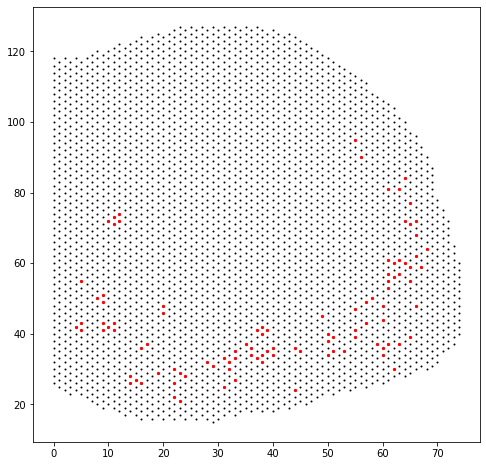

In [119]:
#PLOT PLAQUES

fig = plt.figure(figsize=(8,8))
plt.scatter(rows, cols, s=1, c='k')
plt.scatter(rows[plq_bool], cols[plq_bool], s=5, c='red')
plt.show()

In [376]:
#PLOT CLUSTERS
clust_l, row_ind = list(range(len(np.unique(clust_df['cluster'])))),list(range(len(np.unique(clust_df['cluster']))))
for x in range(len(np.unique(clust_df['cluster']))):
    clust_l[x] = clust_df['cell'][clust_df['cluster'] == x+1]
    row_ind[x] = [np.where(np.array(clust_l[x].iloc[i] == coord_df['barcode'][coord_df['in_tissue']==1] ) ==True)[0][0] for i in range(len(clust_l[x]))]

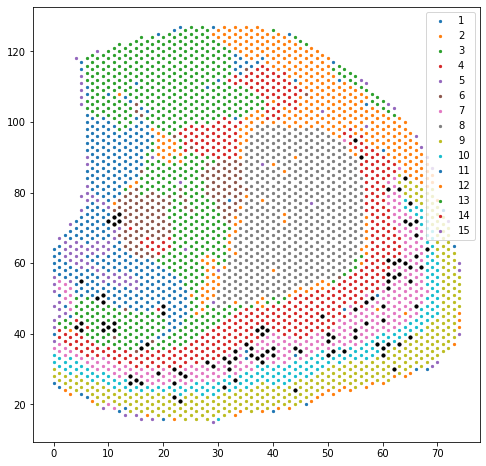

In [389]:
fig = plt.figure(figsize=(8,8))
for x in range(len(np.unique(clust_df['cluster']))): plt.scatter(rows[row_ind[x]], cols[row_ind[x]], s=5, label = str(x+1))
plt.scatter(rows[plq_bool], cols[plq_bool], s=10, c='k')
plt.legend()
plt.show()


In [112]:
#Load spot genes
genes_path = '/cndd2/agelber/hal/qc_aligned/030-D/outs/filtered_feature_bc_matrix.h5'
gene_ = scanpy.read_10x_h5(genes_path)
gene_.var_names_make_unique()

#preprocess genes
scanpy.pp.filter_cells(gene_, min_genes=0)
scanpy.pp.filter_genes(gene_, min_cells=10)
scanpy.pp.normalize_total(gene_, target_sum=1e6)
gene_m = gene_.X.toarray()

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [269]:
#Load spot genes
genes_path = '/cndd2/agelber/hal/qc_aligned/030-D/outs/filtered_feature_bc_matrix.h5'
gene_p = scanpy.read_10x_h5(genes_path)
gene_p.var_names_make_unique()
gene_pm = gene_p.X.toarray()

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# Do differential expression
* plaques vs no plaque within a slice across all genes
* apply within cluster
* Split up and treat each spot as a sample
* Wilcoxon on cpm
* FDR corrected / Bonferroni

In [146]:
gene_m.shape, rows.shape

((3552, 16805), (3552,))

In [433]:
# Compare across entire slice

umi_plq = coord_df['barcode'][coord_df['in_tissue']==1][plq_bool]
umi_norm = coord_df['barcode'][coord_df['in_tissue']==1][plq_bool==False]

geneplq_m = np.vstack([gene_m[np.asarray(umi_plq)[i] == gene_.obs.index] for i in range(len(np.asarray(umi_plq)))])
genenorm_m = np.vstack([gene_m[np.asarray(umi_norm)[i] == gene_.obs.index] for i in range(len(np.asarray(umi_norm)))])
geneplq_m.shape, umi_plq.shape, genenorm_m.shape, umi_norm.shape

import scipy
# Wilcoxon signed rank test
mwu = ([scipy.stats.mannwhitneyu(geneplq_m[:,i], genenorm_m[:,i]) for i in range(gene_m.shape[1])])
p_vals = np.vstack(mwu)[:,1]
sig_ = p_vals < 0.05/gene_m.shape[1]
sig_genes = gene_.var.index[sig_]

In [439]:
sig_genes, geneplq_m.shape, gene_.var.index.shape

(Index(['Vxn', 'Satb2', 'Tuba4a', 'B3galt2', 'Atp1b1', 'Ifi207', 'Cnih3',
        'Hsd11b1', 'Etl4', 'Asb6',
        ...
        'Ina', 'Gucy2g', 'Atp6ap2', 'Syn1', 'Sept6', 'Nsdhl', 'Nap1l2', 'Pgk1',
        'Map7d2', 'humanAPP'],
       dtype='object', length=309),
 (104, 16805),
 (16805,))

In [440]:
# Group by cluster region
def match(curr_umi, umi_plq, umi_norm):
    curr_plq = np.intersect1d(umi_plq,curr_umi)
    curr_norm = np.intersect1d(umi_norm,curr_umi)
    return(curr_norm, curr_plq)

umi_plq = coord_df['barcode'][coord_df['in_tissue']==1][plq_bool]
umi_norm = coord_df['barcode'][coord_df['in_tissue']==1][plq_bool==False]
umi_split_l = [match(clust_l[i], umi_plq, umi_norm) for i in range(len(clust_l))]

In [448]:
#Select cluster 
#Only do DE on clusters with > 5 spots with plaques
for i in range(len(umi_split_l)):
    print('clust ' + str(i) + ' n-plaques=' + str(len(umi_split_l[i][1])))
        


clust 0 n-plaques=4
clust 1 n-plaques=0
clust 2 n-plaques=4
clust 3 n-plaques=16
clust 4 n-plaques=1
clust 5 n-plaques=3
clust 6 n-plaques=46
clust 7 n-plaques=0
clust 8 n-plaques=8
clust 9 n-plaques=13
clust 10 n-plaques=1
clust 11 n-plaques=1
clust 12 n-plaques=6
clust 13 n-plaques=1
clust 14 n-plaques=0


In [454]:
# choose cluster
ch = 3
umi_norm = umi_split_l[ch][0]
umi_plq = umi_split_l[ch][1]
geneplq_m = np.vstack([gene_m[np.asarray(umi_plq)[i] == gene_.obs.index] for i in range(len(np.asarray(umi_plq)))])
genenorm_m = np.vstack([gene_m[np.asarray(umi_norm)[i] == gene_.obs.index] for i in range(len(np.asarray(umi_norm)))])
geneplq_m.shape, genenorm_m.shape

((16, 16805), (318, 16805))

In [455]:
import scipy
# Wilcoxon signed rank test
mwu = ([scipy.stats.mannwhitneyu(geneplq_m[:,i], genenorm_m[:,i]) for i in range(gene_m.shape[1])])
p_vals = np.vstack(mwu)[:,1]
sig_ = p_vals < 0.05/gene_m.shape[1]
sig_genes = gene_.var.index[sig_]

In [456]:
sig_genes, geneplq_m.shape, gene_.var.index.shape

(Index(['Gm13524', 'Tesk2', 'Gm15997', 'A230065N10Rik', 'Gm33680', 'Zfp273',
        'Ankrd66'],
       dtype='object'),
 (16, 16805),
 (16805,))

In [286]:
# Visualise DE genes expression 


1

In [ ]:
# PLot DE gene fold change

In [ ]:
# Gene ontology